In [2]:
import numpy as np
import pandas as pd

def g(x1, x2):    
    return(3*(1-x1)**2 * np.exp(-(x1**2) - (x2+1)**2)
           - 10*(x1/5 - x1**3 - x2**5) * np.exp(-x1**2 - x2**2)
           - 1/3 * np.exp(-(x1+1)**2 - x2**2))
    
def GetGrid(grid):
    x1 = np.linspace(-2, 2, grid)
    x2 = np.linspace(-2, 2, grid)
    x1, x2 = np.meshgrid(x1, x2)
    y = g(x1, x2)
    return x1, x2, y

def create_dataframe(grid):
   x1, x2, y = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': y.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../../results_g/virtual_samples_RationalQuadratic.xlsx")

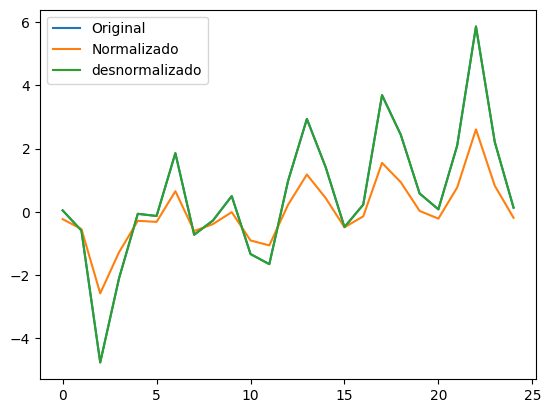

In [3]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import tf_levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.lm_model = lm.model.ModelWrapper(self.model)
        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.loss.MeanSquaredError()
        )

        return(self.lm_model)

2025-07-21 22:15:13.728584: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:15:13.738122: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:15:13.772627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753136113.851689  952296 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753136113.861060  952296 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753136113.881716  952296 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)

    def plot_loss_history(self):
      history = self.results.history
      
      plt.figure(figsize=(8, 5))
      plt.plot(history['loss'], label='Loss de Treinamento')
      plt.plot(history['val_loss'], label='Loss de Validação')
      plt.xlabel('Época')
      plt.ylabel('Loss')
      plt.title('Histórico de Loss')
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights("./content/models/initial-weights/initial-.weights.h5")
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
      
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"./content/models/{fileName}.weights.h5"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./content/models/initial-weights/initial-.weights.h5",
                f"./content/models/initial-weights/{fileName}.weights.h5")

  def SaveDataset(self, trainer, fileName):
    path = f"./content/dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be >= to acsending metrics
        #trainer.plot_loss_history()
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'./content/results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando Com amostras virtuais



In [ ]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=15)
tester.Loop(sort_by='r2_sup',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36], [48], [60]],
            regularizers=[0.02, 0.2],
            learning_rate=[0.01, 0.1])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_1,0.707899,0.522657,0.602988,0.615215,1.216086,3.191994,1.420091,0.719132,0.966560,1.102763,0.602246,1.120130,33.608725,70.573309
model_1_1_0,0.695793,0.513416,0.602397,0.592473,1.266486,3.253787,1.422202,0.761636,1.042185,1.125383,0.585761,1.143106,33.527507,70.492091


DataFrame salvo em ./content/results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
+++++++++++ [1_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
+++++++++++ [1_2] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [1_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_2] | 5 ++++++++++++++++++
Stopped at epoch:  18
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_9,0.821594,0.617125,0.628423,0.780631,0.742749,2.560284,1.329111,0.465356,0.661190,0.861829,0.757064,0.875402,34.594795,71.559379
model_1_2_8,0.805905,0.603356,0.625807,0.779716,0.808062,2.652358,1.338467,0.467297,0.636561,0.898923,0.735701,0.913080,34.426232,71.390816
model_1_2_7,0.804430,0.602092,0.625379,0.779437,0.814206,2.660809,1.339997,0.467888,0.637948,0.902333,0.733692,0.916544,34.411084,71.375668
model_1_2_6,0.797349,0.595942,0.630622,0.769221,0.843686,2.701940,1.321243,0.489562,0.664007,0.918524,0.724049,0.932990,34.339949,71.304532
model_1_2_5,0.789868,0.589528,0.629125,0.765734,0.874828,2.744826,1.326598,0.496958,0.687413,0.935322,0.713863,0.950053,34.267456,71.232040
model_1_2_4,0.778108,0.579615,0.626199,0.759879,0.923790,2.811113,1.337065,0.509378,0.729959,0.961140,0.697849,0.976277,34.158540,71.123124
model_1_2_3,0.738908,0.547444,0.614006,0.735881,1.086988,3.026241,1.380679,0.560287,0.861270,1.042587,0.644470,1.059007,33.833178,70.797762
model_1_2_2,0.736260,0.545322,0.612902,0.734293,1.098012,3.040432,1.384628,0.563654,0.868932,1.047861,0.640865,1.064364,33.812997,70.777580
model_1_2_1,0.731734,0.541668,0.611608,0.730596,1.116855,3.064871,1.389254,0.571499,0.885624,1.056814,0.634702,1.073457,33.778966,70.743550
model_1_2_0,0.729131,0.539584,0.610625,0.728766,1.127693,3.078807,1.392771,0.575380,0.893877,1.061929,0.631157,1.078653,33.759653,70.724237


DataFrame salvo em ./content/results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_9,0.837929,0.627823,0.638556,0.705660,0.674739,2.488751,1.292864,0.824047,0.664619,0.821425,0.779308,0.834362,34.786859,71.751442
model_1_3_8,0.833828,0.625191,0.636504,0.705217,0.691812,2.506352,1.300204,0.825286,0.662646,0.831752,0.773724,0.844852,34.736883,71.701466
model_1_3_7,0.831629,0.623701,0.635169,0.704664,0.700968,2.516311,1.304978,0.826836,0.662061,0.837238,0.770729,0.850424,34.710586,71.675169
model_1_3_6,0.830855,0.623177,0.634673,0.704456,0.704190,2.519817,1.306753,0.827416,0.661936,0.839160,0.769675,0.852376,34.701414,71.665998
model_1_3_5,0.828682,0.621746,0.633341,0.704003,0.713238,2.529386,1.311517,0.828686,0.661585,0.844534,0.766716,0.857835,34.675879,71.640463
model_1_3_4,0.826138,0.620016,0.631588,0.703236,0.723830,2.540954,1.317787,0.830834,0.661446,0.850782,0.763251,0.864181,34.646397,71.610980
model_1_3_3,0.825293,0.619453,0.630983,0.703007,0.727348,2.544723,1.319952,0.831473,0.661413,0.852847,0.762101,0.866278,34.636701,71.601284
model_1_3_2,0.824443,0.618886,0.630366,0.702779,0.730888,2.548508,1.322159,0.832112,0.661402,0.854920,0.760943,0.868384,34.626991,71.591574
model_1_3_1,0.823522,0.618258,0.629683,0.702475,0.734720,2.552714,1.324601,0.832963,0.661422,0.857158,0.759690,0.870657,34.616532,71.581115
model_1_3_0,0.823180,0.618157,0.629548,0.702817,0.736145,2.553388,1.325087,0.832007,0.661193,0.857989,0.759223,0.871501,34.612656,71.577240


DataFrame salvo em ./content/results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_8,0.855349,0.636763,0.633171,0.852973,0.602216,2.428966,1.312128,0.849548,0.704685,0.776026,0.803028,0.788248,35.014277,71.978860
model_1_4_9,0.855111,0.636224,0.630564,0.851326,0.603208,2.432573,1.321450,0.859069,0.709567,0.776664,0.802704,0.788896,35.010988,71.975571
model_1_4_7,0.853366,0.635589,0.634874,0.852239,0.610473,2.436820,1.306036,0.853789,0.697476,0.781328,0.800328,0.793633,34.987042,71.951625
model_1_4_6,0.853064,0.635421,0.634912,0.852034,0.611730,2.437945,1.305899,0.854973,0.696722,0.782131,0.799917,0.794449,34.982930,71.947513
model_1_4_5,0.852797,0.635283,0.634993,0.851885,0.612842,2.438867,1.305609,0.855836,0.696023,0.782842,0.799553,0.795171,34.979297,71.943881
model_1_4_4,0.851515,0.634612,0.635579,0.851296,0.618177,2.443351,1.303512,0.859240,0.692318,0.786242,0.797808,0.798625,34.961960,71.926544
model_1_4_3,0.848393,0.633295,0.637148,0.850414,0.631175,2.452161,1.297900,0.864335,0.683766,0.794465,0.793557,0.806977,34.920343,71.884927
model_1_4_2,0.847974,0.633061,0.637137,0.850131,0.632919,2.453723,1.297939,0.865972,0.683051,0.795562,0.792986,0.808091,34.914826,71.879410
model_1_4_1,0.845243,0.631813,0.638540,0.849560,0.644292,2.462069,1.292920,0.869268,0.676352,0.802678,0.789267,0.815319,34.879207,71.843790
model_1_4_0,0.842246,0.630309,0.638785,0.848213,0.656767,2.472124,1.292044,0.877056,0.670836,0.810411,0.785186,0.823175,34.840853,71.805437


DataFrame salvo em ./content/results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.861285,0.641818,0.619579,0.657435,0.577506,2.395168,1.360743,1.001760,0.825592,0.759938,0.811111,0.771906,35.098074,72.062658
model_1_5_8,0.861315,0.641791,0.620043,0.658046,0.577379,2.395347,1.359086,0.999975,0.823018,0.759854,0.811152,0.771821,35.098513,72.063097
model_1_5_7,0.861260,0.641705,0.620395,0.658551,0.577609,2.395917,1.357827,0.998498,0.820449,0.760006,0.811077,0.771975,35.097715,72.062299
model_1_5_6,0.861107,0.641555,0.620619,0.658948,0.578245,2.396924,1.357023,0.997336,0.817868,0.760424,0.810869,0.772400,35.095516,72.060100
model_1_5_5,0.859689,0.640008,0.624740,0.665612,0.584149,2.407266,1.342282,0.977850,0.781010,0.764296,0.808938,0.776333,35.075198,72.039782
model_1_5_4,0.859491,0.639832,0.624978,0.666075,0.584973,2.408444,1.341434,0.976495,0.777994,0.764836,0.808668,0.776881,35.072378,72.036961
model_1_5_3,0.858967,0.639355,0.625819,0.667607,0.587156,2.411634,1.338425,0.972015,0.768684,0.766261,0.807954,0.778329,35.064930,72.029513
model_1_5_2,0.858750,0.639170,0.626056,0.668088,0.588058,2.412875,1.337576,0.970610,0.765527,0.766849,0.807660,0.778926,35.061861,72.026444
model_1_5_1,0.858248,0.638718,0.627002,0.669764,0.590148,2.415897,1.334191,0.965708,0.755768,0.768211,0.806976,0.780309,35.054764,72.019348
model_1_5_0,0.855414,0.636448,0.630325,0.676454,0.601944,2.431074,1.322305,0.946144,0.713343,0.775851,0.803118,0.788069,35.015181,71.979765


DataFrame salvo em ./content/results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  17
3/3 ━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_9,0.867961,0.660345,0.616240,0.886316,0.549708,2.271271,1.372686,0.461652,0.883295,0.741423,0.820203,0.753100,35.196735,72.161318
model_1_6_8,0.867846,0.660068,0.616267,0.886352,0.550190,2.273124,1.372592,0.461510,0.882273,0.741748,0.820045,0.753429,35.194985,72.159568
model_1_6_7,0.867113,0.658335,0.616393,0.886566,0.553241,2.284717,1.372139,0.460639,0.875988,0.743801,0.819047,0.755516,35.183925,72.148508
model_1_6_6,0.866587,0.657101,0.616467,0.886734,0.555430,2.292967,1.371875,0.459955,0.871654,0.745272,0.818331,0.757009,35.176025,72.140608
model_1_6_5,0.866311,0.656458,0.616501,0.886825,0.556577,2.297264,1.371754,0.459588,0.869448,0.746041,0.817956,0.757791,35.171898,72.136482
model_1_6_4,0.866328,0.654588,0.618277,0.890157,0.556511,2.309770,1.365403,0.446057,0.859546,0.745996,0.817978,0.757745,35.172138,72.136722
model_1_6_3,0.864329,0.649901,0.618441,0.890899,0.564831,2.341111,1.364814,0.443042,0.845243,0.751553,0.815256,0.763389,35.142456,72.107040
model_1_6_2,0.863687,0.647070,0.619707,0.893403,0.567503,2.360044,1.360286,0.432875,0.836878,0.753328,0.814383,0.765192,35.133019,72.097603
model_1_6_1,0.863481,0.646584,0.619728,0.893491,0.568363,2.363293,1.360211,0.432519,0.835742,0.753898,0.814101,0.765772,35.129990,72.094574
model_1_6_0,0.863360,0.646152,0.619871,0.893796,0.568864,2.366184,1.359698,0.431280,0.834601,0.754231,0.813937,0.766109,35.128227,72.092810


DataFrame salvo em ./content/results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_9,0.873578,0.672430,0.628024,0.923728,0.526324,2.190462,1.330538,0.425688,0.832852,0.725482,0.827851,0.736908,35.283676,72.248260
model_1_7_8,0.873395,0.671739,0.627594,0.924566,0.527087,2.195082,1.332076,0.421011,0.835242,0.726008,0.827602,0.737442,35.280778,72.245362
model_1_7_7,0.873354,0.671595,0.627502,0.924734,0.527258,2.196046,1.332405,0.420071,0.835787,0.726125,0.827546,0.737561,35.280130,72.244714
model_1_7_6,0.872838,0.669746,0.626057,0.926957,0.529408,2.208413,1.337571,0.407667,0.843928,0.727604,0.826843,0.739063,35.271992,72.236576
model_1_7_5,0.871950,0.667304,0.623897,0.929535,0.533102,2.224739,1.345297,0.393277,0.853364,0.730138,0.825634,0.741637,35.258084,72.222668
model_1_7_4,0.871859,0.667099,0.623713,0.929721,0.533481,2.226108,1.345956,0.392241,0.854124,0.730398,0.825510,0.741901,35.256665,72.221248
model_1_7_3,0.870838,0.664951,0.621420,0.931703,0.537734,2.240477,1.354160,0.381176,0.863648,0.733303,0.824119,0.744852,35.240783,72.205366
model_1_7_2,0.870606,0.664501,0.620960,0.932064,0.538699,2.243484,1.355803,0.379164,0.865530,0.733961,0.823804,0.745520,35.237198,72.201782
model_1_7_1,0.870334,0.664015,0.620449,0.932426,0.539832,2.246734,1.357633,0.377142,0.867546,0.734732,0.823433,0.746304,35.232996,72.197580
model_1_7_0,0.870065,0.663534,0.619940,0.932779,0.540951,2.249947,1.359452,0.375173,0.869650,0.735494,0.823067,0.747077,35.228853,72.193437


DataFrame salvo em ./content/results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_0,0.873688,0.672613,0.628366,0.830025,0.525869,2.189236,1.329312,0.630109,0.822241,0.725168,0.828000,0.736589,35.285406,72.249990
model_1_8_7,0.872805,0.671710,0.629542,0.816187,0.529542,2.195277,1.325109,0.681405,0.754451,0.727696,0.826799,0.739157,35.271487,72.236071
model_1_8_9,0.872748,0.671696,0.629591,0.815436,0.529779,2.195372,1.324931,0.684189,0.750585,0.727859,0.826721,0.739322,35.270592,72.235176
model_1_8_8,0.872749,0.671655,0.629545,0.815737,0.529777,2.195643,1.325095,0.683073,0.752506,0.727858,0.826722,0.739321,35.270599,72.235183
model_1_8_6,0.872796,0.671655,0.629488,0.816473,0.529579,2.195644,1.325300,0.680346,0.756409,0.727722,0.826787,0.739183,35.271346,72.235930
model_1_8_5,0.872800,0.671505,0.629296,0.817758,0.529564,2.196648,1.325987,0.675581,0.764435,0.727711,0.826792,0.739172,35.271404,72.235988
model_1_8_4,0.872787,0.671446,0.629236,0.818057,0.529618,2.197044,1.326203,0.674476,0.766491,0.727749,0.826774,0.739210,35.271197,72.235781
model_1_8_3,0.872777,0.671394,0.629176,0.818368,0.529659,2.197391,1.326417,0.673321,0.768561,0.727777,0.826760,0.739239,35.271043,72.235627
model_1_8_2,0.872760,0.671331,0.629111,0.818667,0.529729,2.197814,1.326649,0.672214,0.770654,0.727825,0.826737,0.739287,35.270779,72.235363
model_1_8_1,0.872648,0.670921,0.628641,0.820919,0.530195,2.200551,1.328330,0.663864,0.785917,0.728145,0.826585,0.739612,35.269022,72.233605


DataFrame salvo em ./content/results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_0,0.872882,0.671447,0.629188,0.784912,0.529223,2.197034,1.326374,0.806196,0.753103,0.727477,0.826903,0.738934,35.272692,72.237275
model_1_9_1,0.873042,0.671077,0.628565,0.782595,0.528557,2.199507,1.328601,0.814880,0.756822,0.727019,0.827121,0.738469,35.275208,72.239792
model_1_9_2,0.873151,0.670704,0.627919,0.780166,0.528103,2.202001,1.330913,0.823983,0.760504,0.726707,0.827269,0.738152,35.276927,72.241511
model_1_9_3,0.873217,0.670339,0.627257,0.777672,0.527826,2.204444,1.333279,0.833332,0.764169,0.726516,0.827360,0.737958,35.277977,72.242560
model_1_9_4,0.873230,0.670216,0.627033,0.776817,0.527775,2.205264,1.334082,0.836537,0.765373,0.726481,0.827377,0.737923,35.278169,72.242753
model_1_9_5,0.873238,0.670096,0.626807,0.775961,0.527741,2.206069,1.334888,0.839745,0.766568,0.726458,0.827388,0.737899,35.278301,72.242885
model_1_9_6,0.873242,0.669975,0.626579,0.775095,0.527725,2.206881,1.335706,0.842991,0.767760,0.726447,0.827393,0.737887,35.278361,72.242945
model_1_9_7,0.873241,0.669852,0.626351,0.774217,0.527729,2.207701,1.336519,0.846280,0.768928,0.726450,0.827392,0.737891,35.278344,72.242928
model_1_9_8,0.872626,0.667747,0.622135,0.757742,0.530290,2.221774,1.351602,0.908032,0.788455,0.728210,0.826554,0.739679,35.268664,72.233247
model_1_9_9,0.872152,0.666963,0.620490,0.751170,0.532263,2.227022,1.357486,0.932667,0.795240,0.729564,0.825909,0.741054,35.261233,72.225817


DataFrame salvo em ./content/results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_9,0.872992,0.673702,0.595640,0.834620,0.528763,2.181956,1.446373,0.521694,0.865675,0.727161,0.827054,0.738613,35.274431,72.239014
model_1_10_8,0.873056,0.673564,0.596222,0.836065,0.528500,2.182880,1.444292,0.517133,0.864621,0.726980,0.827140,0.738429,35.275425,72.240009
model_1_10_7,0.873117,0.673421,0.596813,0.837536,0.528245,2.183835,1.442178,0.512495,0.863539,0.726804,0.827223,0.738251,35.276391,72.240975
model_1_10_6,0.873175,0.673276,0.597406,0.839002,0.528001,2.184804,1.440056,0.507870,0.862433,0.726637,0.827303,0.738081,35.277315,72.241898
model_1_10_5,0.873649,0.671062,0.605837,0.859503,0.526028,2.199607,1.409899,0.443199,0.844256,0.725278,0.827948,0.736701,35.284800,72.249383
model_1_10_4,0.873634,0.670660,0.607055,0.862481,0.526093,2.202297,1.405540,0.433803,0.841145,0.725323,0.827927,0.736746,35.284553,72.249137
model_1_10_3,0.873589,0.670230,0.608268,0.865447,0.526279,2.205173,1.401203,0.424448,0.837901,0.725451,0.827866,0.736876,35.283847,72.248431
model_1_10_2,0.873059,0.668411,0.617770,0.883934,0.528485,2.217334,1.367215,0.366132,0.808086,0.726970,0.827144,0.738419,35.275482,72.240065
model_1_10_1,0.872905,0.668131,0.618335,0.885222,0.529127,2.219206,1.365192,0.362068,0.805626,0.727411,0.826935,0.738867,35.273055,72.237638
model_1_10_0,0.872737,0.667846,0.618892,0.886484,0.529825,2.221114,1.363201,0.358088,0.803095,0.727891,0.826706,0.739354,35.270418,72.235002


DataFrame salvo em ./content/results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_9,0.873344,0.680389,0.589725,0.526545,0.527301,2.137239,1.467530,0.851802,0.902779,0.726155,0.827532,0.737591,35.279967,72.244550
model_1_11_8,0.873389,0.680323,0.589980,0.527884,0.527111,2.137685,1.466616,0.849393,0.901422,0.726024,0.827594,0.737458,35.280687,72.245271
model_1_11_7,0.873434,0.680251,0.590234,0.529230,0.526925,2.138162,1.465708,0.846972,0.900050,0.725896,0.827655,0.737328,35.281393,72.245976
model_1_11_6,0.873477,0.680175,0.590490,0.530585,0.526746,2.138671,1.464794,0.844534,0.898669,0.725772,0.827713,0.737203,35.282075,72.246658
model_1_11_5,0.873808,0.677420,0.594761,0.556433,0.525369,2.157092,1.449515,0.798030,0.872907,0.724824,0.828163,0.736239,35.287307,72.251891
model_1_11_4,0.873779,0.677141,0.594941,0.557864,0.525490,2.158957,1.448872,0.795456,0.871992,0.724907,0.828124,0.736324,35.286848,72.251431
model_1_11_3,0.873741,0.676843,0.595108,0.559276,0.525646,2.160955,1.448274,0.792915,0.871073,0.725015,0.828073,0.736433,35.286253,72.250837
model_1_11_2,0.873693,0.676552,0.595242,0.560522,0.525846,2.162900,1.447795,0.790674,0.870175,0.725153,0.828007,0.736573,35.285492,72.250076
model_1_11_1,0.873635,0.676211,0.595378,0.561885,0.526087,2.165179,1.447310,0.788221,0.869251,0.725318,0.827929,0.736741,35.284579,72.249163
model_1_11_0,0.873565,0.675862,0.595487,0.563127,0.526378,2.167514,1.446919,0.785987,0.868337,0.725519,0.827834,0.736945,35.283471,72.248055


DataFrame salvo em ./content/results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_0,0.873346,0.680281,0.589792,0.292009,0.527293,2.137961,1.467292,0.777249,0.904005,0.726149,0.827534,0.737585,35.279999,72.244582
model_1_12_1,0.873345,0.680172,0.589856,0.289240,0.527295,2.138692,1.467062,0.780288,0.905209,0.726151,0.827534,0.737587,35.279992,72.244575
model_1_12_2,0.873342,0.680062,0.589917,0.286488,0.527309,2.139427,1.466842,0.783310,0.906383,0.726160,0.827529,0.737597,35.279938,72.244522
model_1_12_3,0.873335,0.679952,0.589979,0.283738,0.527337,2.140160,1.466622,0.786329,0.907535,0.726180,0.827520,0.737616,35.279832,72.244415
model_1_12_4,0.873315,0.679730,0.590104,0.278329,0.527419,2.141647,1.466175,0.792266,0.909730,0.726236,0.827493,0.737674,35.279519,72.244102
model_1_12_5,0.873306,0.679603,0.590187,0.275822,0.527455,2.142494,1.465877,0.795018,0.910758,0.726261,0.827481,0.737699,35.279382,72.243966
model_1_12_6,0.873291,0.679492,0.590244,0.273152,0.527522,2.143241,1.465672,0.797950,0.911801,0.726307,0.827459,0.737746,35.279130,72.243714
model_1_12_7,0.873232,0.679154,0.590422,0.265303,0.527767,2.145501,1.465037,0.806567,0.914766,0.726476,0.827379,0.737917,35.278201,72.242785
model_1_12_8,0.873067,0.678474,0.590756,0.250161,0.528451,2.150043,1.463842,0.823190,0.920062,0.726946,0.827156,0.738395,35.275611,72.240194
model_1_12_9,0.873036,0.678359,0.590812,0.247742,0.528581,2.150818,1.463641,0.825845,0.920873,0.727036,0.827113,0.738486,35.275117,72.239701


DataFrame salvo em ./content/results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_1,0.872675,0.678393,0.590822,0.863103,0.530082,2.150588,1.463608,0.468315,0.927516,0.728068,0.826622,0.739534,35.269445,72.234029
model_1_13_0,0.872862,0.678375,0.590820,0.865147,0.529306,2.150707,1.463612,0.461323,0.924175,0.727534,0.826876,0.738992,35.272376,72.236959
model_1_13_2,0.870685,0.678166,0.591268,0.843926,0.538368,2.152103,1.462011,0.533918,0.957516,0.733736,0.823912,0.745291,35.238426,72.203009
model_1_13_3,0.870399,0.678126,0.591277,0.841451,0.539560,2.152371,1.461977,0.542385,0.960966,0.734548,0.823522,0.746116,35.234002,72.198586
model_1_13_4,0.868167,0.677440,0.592076,0.823111,0.548852,2.156960,1.459120,0.605125,0.987613,0.740846,0.820483,0.752513,35.199851,72.164435
model_1_13_5,0.864274,0.676367,0.592234,0.794042,0.565060,2.164132,1.458556,0.704568,1.022420,0.751705,0.815182,0.763543,35.141647,72.106231
model_1_13_6,0.863844,0.676238,0.592240,0.790955,0.566849,2.165000,1.458535,0.715131,1.025864,0.752893,0.814597,0.764751,35.135326,72.099910
model_1_13_7,0.862546,0.675827,0.592284,0.781714,0.572255,2.167743,1.458377,0.746744,1.036044,0.756476,0.812828,0.768389,35.116340,72.080924
model_1_13_8,0.861204,0.675393,0.592315,0.772303,0.577840,2.170645,1.458265,0.778937,1.046068,0.760158,0.811001,0.772130,35.096916,72.061500
model_1_13_9,0.860488,0.675052,0.592591,0.767344,0.580824,2.172930,1.457278,0.795900,1.052176,0.762118,0.810026,0.774120,35.086616,72.051200


DataFrame salvo em ./content/results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  19
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_8,0.866997,0.676906,0.593872,0.885472,0.553725,2.160529,1.452698,0.311992,1.004401,0.744127,0.818889,0.755846,35.182175,72.146758
model_1_14_7,0.866852,0.676873,0.593860,0.886058,0.554326,2.160749,1.452738,0.310394,1.005849,0.744531,0.818692,0.756257,35.180003,72.144586
model_1_14_6,0.866703,0.676838,0.593847,0.886650,0.554946,2.160983,1.452784,0.308783,1.007301,0.744947,0.818489,0.756679,35.177767,72.142351
model_1_14_5,0.866534,0.676803,0.593813,0.887230,0.555650,2.161221,1.452908,0.307203,1.008804,0.745419,0.818259,0.757159,35.175233,72.139817
model_1_14_4,0.866375,0.676764,0.593795,0.887831,0.556311,2.161482,1.452973,0.305567,1.010297,0.745863,0.818043,0.757610,35.172854,72.137437
model_1_14_3,0.866186,0.676726,0.593741,0.888406,0.557101,2.161733,1.453165,0.303998,1.011853,0.746392,0.817785,0.758147,35.170018,72.134601
model_1_14_2,0.865969,0.676691,0.593655,0.888962,0.558005,2.161971,1.453472,0.302485,1.013488,0.746997,0.817489,0.758762,35.166776,72.131359
model_1_14_1,0.864820,0.676407,0.593443,0.892711,0.562786,2.163869,1.454230,0.292272,1.022959,0.750190,0.815925,0.762005,35.149713,72.114297
model_1_14_0,0.864193,0.676226,0.593341,0.894690,0.565399,2.165080,1.454596,0.286881,1.027848,0.751930,0.815071,0.763772,35.140449,72.105032
model_1_14_9,0.871509,0.672376,0.599220,0.883191,0.534939,2.190823,1.433568,0.318206,0.964754,0.731395,0.825033,0.742914,35.251205,72.215789


DataFrame salvo em ./content/results/metrics_1_14
Testando combinacao2: Hidden Size=[4], regularizer=0.02, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  16
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/ste

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_0_8,0.941571,0.770261,0.764640,0.929342,0.243254,1.536266,0.841868,0.349824,1.171547,0.493208,0.920437,0.500976,36.827295,73.791878
model_2_0_7,0.941798,0.770210,0.764200,0.930434,0.242309,1.536605,0.843444,0.344418,1.161766,0.492249,0.920746,0.500002,36.835080,73.799664
model_2_0_9,0.941236,0.770089,0.765663,0.927653,0.244649,1.537418,0.838209,0.358187,1.191085,0.494620,0.919981,0.502410,36.815864,73.780447
model_2_0_6,0.941920,0.769827,0.764344,0.931056,0.241799,1.539166,0.842927,0.341337,1.160151,0.491731,0.920913,0.499475,36.839295,73.803879
model_2_0_5,0.942154,0.769146,0.763978,0.932340,0.240827,1.543720,0.844236,0.334981,1.146569,0.490742,0.921231,0.498470,36.847349,73.811932
model_2_0_4,0.942280,0.767413,0.764132,0.933649,0.240301,1.555313,0.843688,0.328500,1.131695,0.490205,0.921403,0.497926,36.851724,73.816307
model_2_0_3,0.941814,0.763116,0.765220,0.934651,0.242242,1.584041,0.839793,0.323541,1.115589,0.492180,0.920768,0.499932,36.835640,73.800224
model_2_0_2,0.938235,0.752167,0.766752,0.933133,0.257142,1.657260,0.834314,0.331054,1.104742,0.507092,0.915895,0.515078,36.716251,73.680835
model_2_0_1,0.918737,0.721898,0.757106,0.918314,0.338318,1.859670,0.868819,0.404420,1.166134,0.581651,0.889344,0.590811,36.167539,73.132123
model_2_0_0,0.816168,0.618730,0.674685,0.817005,0.765335,2.549553,1.163632,0.905998,1.550036,0.874834,0.749676,0.888612,34.534884,71.499468


DataFrame salvo em ./content/results/metrics_2_0
+++++++++++ [2_1] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [2_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_1] | 5 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_1_4,0.943049,0.773162,0.731383,0.869983,0.237101,1.516869,0.960827,0.362555,1.074314,0.486931,0.922449,0.494599,36.878535,73.843118
model_2_1_2,0.944058,0.772583,0.741950,0.890517,0.232899,1.520741,0.923032,0.305293,1.063116,0.482596,0.923824,0.490196,36.914303,73.878886
model_2_1_1,0.944031,0.772384,0.743080,0.891736,0.233013,1.522066,0.918986,0.301896,1.067756,0.482714,0.923787,0.490316,36.913325,73.877909
model_2_1_7,0.941985,0.772383,0.726200,0.859498,0.241532,1.522076,0.979367,0.391791,1.097723,0.491459,0.921000,0.499199,36.841504,73.806088
model_2_1_3,0.943403,0.771939,0.738531,0.876240,0.235628,1.525043,0.935260,0.345107,1.100784,0.485415,0.922931,0.493060,36.891001,73.855585
model_2_1_6,0.942005,0.771694,0.728475,0.859988,0.241447,1.526685,0.971227,0.390425,1.116436,0.491372,0.921028,0.499111,36.842214,73.806797
model_2_1_5,0.942043,0.771666,0.728835,0.860394,0.241288,1.526872,0.969941,0.389292,1.117061,0.491211,0.921080,0.498947,36.843524,73.808108
model_2_1_8,0.941325,0.771510,0.723500,0.853946,0.244276,1.527911,0.989024,0.407273,1.116626,0.494243,0.920103,0.502027,36.818912,73.783496
model_2_1_9,0.941113,0.771220,0.722542,0.852257,0.245162,1.529855,0.992453,0.411983,1.122354,0.495138,0.919813,0.502936,36.811675,73.776259
model_2_1_0,0.942490,0.771041,0.758984,0.901512,0.239426,1.531050,0.862100,0.274635,1.132825,0.489312,0.921689,0.497018,36.859018,73.823602


DataFrame salvo em ./content/results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  18
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_2_2,0.942076,0.773245,0.729476,0.931351,0.241153,1.516314,0.967649,0.326079,0.864297,0.491074,0.921124,0.498808,36.844645,73.809229
model_2_2_1,0.942988,0.772976,0.730476,0.940827,0.237356,1.518109,0.964073,0.281070,0.951441,0.487192,0.922366,0.494865,36.876389,73.840972
model_2_2_0,0.942727,0.772140,0.728394,0.947964,0.238441,1.523704,0.971520,0.247167,1.030539,0.488304,0.922011,0.495995,36.867266,73.831849
model_2_2_3,0.941557,0.771897,0.727657,0.928377,0.243311,1.525326,0.974154,0.340205,0.828345,0.493266,0.920418,0.501034,36.826829,73.791413
model_2_2_4,0.941551,0.771867,0.727641,0.928349,0.243337,1.525524,0.974212,0.340339,0.827983,0.493292,0.920410,0.501061,36.826617,73.791201
model_2_2_5,0.941550,0.771848,0.727653,0.928344,0.243341,1.525656,0.974168,0.340362,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_2_6,0.941550,0.771848,0.727653,0.928344,0.243341,1.525656,0.974168,0.340362,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_2_7,0.941550,0.771848,0.727653,0.928344,0.243341,1.525656,0.974168,0.340362,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_2_8,0.941550,0.771848,0.727653,0.928344,0.243341,1.525656,0.974168,0.340362,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_2_9,0.941550,0.771848,0.727653,0.928344,0.243341,1.525656,0.974168,0.340362,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169


DataFrame salvo em ./content/results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_3_0,0.94155,0.771848,0.727653,0.952503,0.243341,1.525656,0.974168,0.072963,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_3_1,0.94155,0.771848,0.727653,0.952503,0.243341,1.525656,0.974168,0.072963,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_3_2,0.94155,0.771848,0.727653,0.952503,0.243341,1.525656,0.974168,0.072963,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_3_3,0.94155,0.771848,0.727653,0.952503,0.243341,1.525656,0.974168,0.072963,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_3_4,0.94155,0.771848,0.727653,0.952503,0.243341,1.525656,0.974168,0.072963,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_3_5,0.94155,0.771848,0.727653,0.952503,0.243341,1.525656,0.974168,0.072963,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_3_6,0.94155,0.771848,0.727653,0.952503,0.243341,1.525656,0.974168,0.072963,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_3_7,0.94155,0.771848,0.727653,0.952503,0.243341,1.525656,0.974168,0.072963,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_3_8,0.94155,0.771848,0.727653,0.952503,0.243341,1.525656,0.974168,0.072963,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_3_9,0.94155,0.771848,0.727653,0.952503,0.243341,1.525656,0.974168,0.072963,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169


DataFrame salvo em ./content/results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_4_0,0.94155,0.771848,0.727653,0.906365,0.243341,1.525656,0.974168,0.221193,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_4_1,0.94155,0.771848,0.727653,0.906365,0.243341,1.525656,0.974168,0.221193,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_4_2,0.94155,0.771848,0.727653,0.906365,0.243341,1.525656,0.974168,0.221193,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_4_3,0.94155,0.771848,0.727653,0.906365,0.243341,1.525656,0.974168,0.221193,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_4_4,0.94155,0.771848,0.727653,0.906365,0.243341,1.525656,0.974168,0.221193,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_4_5,0.94155,0.771848,0.727653,0.906365,0.243341,1.525656,0.974168,0.221193,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_4_6,0.94155,0.771848,0.727653,0.906365,0.243341,1.525656,0.974168,0.221193,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_4_7,0.94155,0.771848,0.727653,0.906365,0.243341,1.525656,0.974168,0.221193,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_4_8,0.94155,0.771848,0.727653,0.906365,0.243341,1.525656,0.974168,0.221193,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_4_9,0.94155,0.771848,0.727653,0.906365,0.243341,1.525656,0.974168,0.221193,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169


DataFrame salvo em ./content/results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_5_0,0.94155,0.771848,0.727653,0.907683,0.243341,1.525656,0.974168,0.166927,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_5_1,0.94155,0.771848,0.727653,0.907683,0.243341,1.525656,0.974168,0.166927,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_5_2,0.94155,0.771848,0.727653,0.907683,0.243341,1.525656,0.974168,0.166927,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_5_3,0.94155,0.771848,0.727653,0.907683,0.243341,1.525656,0.974168,0.166927,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_5_4,0.94155,0.771848,0.727653,0.907683,0.243341,1.525656,0.974168,0.166927,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_5_5,0.94155,0.771848,0.727653,0.907683,0.243341,1.525656,0.974168,0.166927,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_5_6,0.94155,0.771848,0.727653,0.907683,0.243341,1.525656,0.974168,0.166927,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_5_7,0.94155,0.771848,0.727653,0.907683,0.243341,1.525656,0.974168,0.166927,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_5_8,0.94155,0.771848,0.727653,0.907683,0.243341,1.525656,0.974168,0.166927,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_5_9,0.94155,0.771848,0.727653,0.907683,0.243341,1.525656,0.974168,0.166927,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169


DataFrame salvo em ./content/results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_6_0,0.94155,0.771848,0.727653,0.941222,0.243341,1.525656,0.974168,0.235351,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_6_1,0.94155,0.771848,0.727653,0.941222,0.243341,1.525656,0.974168,0.235351,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_6_2,0.94155,0.771848,0.727653,0.941222,0.243341,1.525656,0.974168,0.235351,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_6_3,0.94155,0.771848,0.727653,0.941222,0.243341,1.525656,0.974168,0.235351,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_6_4,0.94155,0.771848,0.727653,0.941222,0.243341,1.525656,0.974168,0.235351,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_6_5,0.94155,0.771848,0.727653,0.941222,0.243341,1.525656,0.974168,0.235351,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_6_6,0.94155,0.771848,0.727653,0.941222,0.243341,1.525656,0.974168,0.235351,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_6_7,0.94155,0.771848,0.727653,0.941222,0.243341,1.525656,0.974168,0.235351,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_6_8,0.94155,0.771848,0.727653,0.941222,0.243341,1.525656,0.974168,0.235351,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_6_9,0.94155,0.771848,0.727653,0.941222,0.243341,1.525656,0.974168,0.235351,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169


DataFrame salvo em ./content/results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_7_0,0.94155,0.771848,0.727653,0.914803,0.243341,1.525656,0.974168,0.321491,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_7_1,0.94155,0.771848,0.727653,0.914803,0.243341,1.525656,0.974168,0.321491,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_7_2,0.94155,0.771848,0.727653,0.914803,0.243341,1.525656,0.974168,0.321491,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_7_3,0.94155,0.771848,0.727653,0.914803,0.243341,1.525656,0.974168,0.321491,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_7_4,0.94155,0.771848,0.727653,0.914803,0.243341,1.525656,0.974168,0.321491,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_7_5,0.94155,0.771848,0.727653,0.914803,0.243341,1.525656,0.974168,0.321491,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_7_6,0.94155,0.771848,0.727653,0.914803,0.243341,1.525656,0.974168,0.321491,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_7_7,0.94155,0.771848,0.727653,0.914803,0.243341,1.525656,0.974168,0.321491,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_7_8,0.94155,0.771848,0.727653,0.914803,0.243341,1.525656,0.974168,0.321491,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_7_9,0.94155,0.771848,0.727653,0.914803,0.243341,1.525656,0.974168,0.321491,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169


DataFrame salvo em ./content/results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_8_0,0.94155,0.771848,0.727653,0.961932,0.243341,1.525656,0.974168,0.225849,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_8_1,0.94155,0.771848,0.727653,0.961932,0.243341,1.525656,0.974168,0.225849,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_8_2,0.94155,0.771848,0.727653,0.961932,0.243341,1.525656,0.974168,0.225849,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_8_3,0.94155,0.771848,0.727653,0.961932,0.243341,1.525656,0.974168,0.225849,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_8_4,0.94155,0.771848,0.727653,0.961932,0.243341,1.525656,0.974168,0.225849,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_8_5,0.94155,0.771848,0.727653,0.961932,0.243341,1.525656,0.974168,0.225849,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_8_6,0.94155,0.771848,0.727653,0.961932,0.243341,1.525656,0.974168,0.225849,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_8_7,0.94155,0.771848,0.727653,0.961932,0.243341,1.525656,0.974168,0.225849,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_8_8,0.94155,0.771848,0.727653,0.961932,0.243341,1.525656,0.974168,0.225849,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_8_9,0.94155,0.771848,0.727653,0.961932,0.243341,1.525656,0.974168,0.225849,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169


DataFrame salvo em ./content/results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_9_0,0.94155,0.771848,0.727653,0.920154,0.243341,1.525656,0.974168,0.212293,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_9_1,0.94155,0.771848,0.727653,0.920154,0.243341,1.525656,0.974168,0.212293,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_9_2,0.94155,0.771848,0.727653,0.920154,0.243341,1.525656,0.974168,0.212293,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_9_3,0.94155,0.771848,0.727653,0.920154,0.243341,1.525656,0.974168,0.212293,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_9_4,0.94155,0.771848,0.727653,0.920154,0.243341,1.525656,0.974168,0.212293,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_9_5,0.94155,0.771848,0.727653,0.920154,0.243341,1.525656,0.974168,0.212293,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_9_6,0.94155,0.771848,0.727653,0.920154,0.243341,1.525656,0.974168,0.212293,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_9_7,0.94155,0.771848,0.727653,0.920154,0.243341,1.525656,0.974168,0.212293,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_9_8,0.94155,0.771848,0.727653,0.920154,0.243341,1.525656,0.974168,0.212293,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_9_9,0.94155,0.771848,0.727653,0.920154,0.243341,1.525656,0.974168,0.212293,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169


DataFrame salvo em ./content/results/metrics_2_9
+++++++++++ [2_10] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [2_10] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
+++++++++++ [2_10] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [2_10] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
+++++++++++ [2_10] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_10_0,0.94155,0.771848,0.727653,0.920303,0.243341,1.525656,0.974168,0.198064,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_10_1,0.94155,0.771848,0.727653,0.920303,0.243341,1.525656,0.974168,0.198064,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_10_2,0.94155,0.771848,0.727653,0.920303,0.243341,1.525656,0.974168,0.198064,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_10_3,0.94155,0.771848,0.727653,0.920303,0.243341,1.525656,0.974168,0.198064,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_10_4,0.94155,0.771848,0.727653,0.920303,0.243341,1.525656,0.974168,0.198064,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_10_5,0.94155,0.771848,0.727653,0.920303,0.243341,1.525656,0.974168,0.198064,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_10_6,0.94155,0.771848,0.727653,0.920303,0.243341,1.525656,0.974168,0.198064,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_10_7,0.94155,0.771848,0.727653,0.920303,0.243341,1.525656,0.974168,0.198064,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_10_8,0.94155,0.771848,0.727653,0.920303,0.243341,1.525656,0.974168,0.198064,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_10_9,0.94155,0.771848,0.727653,0.920303,0.243341,1.525656,0.974168,0.198064,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169


DataFrame salvo em ./content/results/metrics_2_10
+++++++++++ [2_11] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [2_11] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [2_11] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [2_11] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [2_11] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_11_0,0.94155,0.771848,0.727653,0.90819,0.243341,1.525656,0.974168,0.224441,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_11_1,0.94155,0.771848,0.727653,0.90819,0.243341,1.525656,0.974168,0.224441,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_11_2,0.94155,0.771848,0.727653,0.90819,0.243341,1.525656,0.974168,0.224441,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_11_3,0.94155,0.771848,0.727653,0.90819,0.243341,1.525656,0.974168,0.224441,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_11_4,0.94155,0.771848,0.727653,0.90819,0.243341,1.525656,0.974168,0.224441,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_11_5,0.94155,0.771848,0.727653,0.90819,0.243341,1.525656,0.974168,0.224441,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_11_6,0.94155,0.771848,0.727653,0.90819,0.243341,1.525656,0.974168,0.224441,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_11_7,0.94155,0.771848,0.727653,0.90819,0.243341,1.525656,0.974168,0.224441,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_11_8,0.94155,0.771848,0.727653,0.90819,0.243341,1.525656,0.974168,0.224441,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_11_9,0.94155,0.771848,0.727653,0.90819,0.243341,1.525656,0.974168,0.224441,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169


DataFrame salvo em ./content/results/metrics_2_11
+++++++++++ [2_12] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [2_12] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [2_12] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [2_12] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [2_12] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_12_0,0.94155,0.771848,0.727653,0.953424,0.243341,1.525656,0.974168,0.240782,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_12_1,0.94155,0.771848,0.727653,0.953424,0.243341,1.525656,0.974168,0.240782,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_12_2,0.94155,0.771848,0.727653,0.953424,0.243341,1.525656,0.974168,0.240782,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_12_3,0.94155,0.771848,0.727653,0.953424,0.243341,1.525656,0.974168,0.240782,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_12_4,0.94155,0.771848,0.727653,0.953424,0.243341,1.525656,0.974168,0.240782,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_12_5,0.94155,0.771848,0.727653,0.953424,0.243341,1.525656,0.974168,0.240782,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_12_6,0.94155,0.771848,0.727653,0.953424,0.243341,1.525656,0.974168,0.240782,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_12_7,0.94155,0.771848,0.727653,0.953424,0.243341,1.525656,0.974168,0.240782,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_12_8,0.94155,0.771848,0.727653,0.953424,0.243341,1.525656,0.974168,0.240782,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_12_9,0.94155,0.771848,0.727653,0.953424,0.243341,1.525656,0.974168,0.240782,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169


DataFrame salvo em ./content/results/metrics_2_12
+++++++++++ [2_13] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [2_13] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [2_13] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [2_13] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_13] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_13_0,0.94155,0.771848,0.727653,0.898062,0.243341,1.525656,0.974168,0.260569,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_13_1,0.94155,0.771848,0.727653,0.898062,0.243341,1.525656,0.974168,0.260569,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_13_2,0.94155,0.771848,0.727653,0.898062,0.243341,1.525656,0.974168,0.260569,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_13_3,0.94155,0.771848,0.727653,0.898062,0.243341,1.525656,0.974168,0.260569,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_13_4,0.94155,0.771848,0.727653,0.898062,0.243341,1.525656,0.974168,0.260569,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_13_5,0.94155,0.771848,0.727653,0.898062,0.243341,1.525656,0.974168,0.260569,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_13_6,0.94155,0.771848,0.727653,0.898062,0.243341,1.525656,0.974168,0.260569,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_13_7,0.94155,0.771848,0.727653,0.898062,0.243341,1.525656,0.974168,0.260569,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_13_8,0.94155,0.771848,0.727653,0.898062,0.243341,1.525656,0.974168,0.260569,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_13_9,0.94155,0.771848,0.727653,0.898062,0.243341,1.525656,0.974168,0.260569,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169


DataFrame salvo em ./content/results/metrics_2_13
+++++++++++ [2_14] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [2_14] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
+++++++++++ [2_14] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [2_14] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [2_14] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_14_0,0.94155,0.771848,0.727653,0.904138,0.243341,1.525656,0.974168,0.247244,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_14_1,0.94155,0.771848,0.727653,0.904138,0.243341,1.525656,0.974168,0.247244,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_14_2,0.94155,0.771848,0.727653,0.904138,0.243341,1.525656,0.974168,0.247244,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_14_3,0.94155,0.771848,0.727653,0.904138,0.243341,1.525656,0.974168,0.247244,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_14_4,0.94155,0.771848,0.727653,0.904138,0.243341,1.525656,0.974168,0.247244,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_14_5,0.94155,0.771848,0.727653,0.904138,0.243341,1.525656,0.974168,0.247244,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_14_6,0.94155,0.771848,0.727653,0.904138,0.243341,1.525656,0.974168,0.247244,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_14_7,0.94155,0.771848,0.727653,0.904138,0.243341,1.525656,0.974168,0.247244,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_14_8,0.94155,0.771848,0.727653,0.904138,0.243341,1.525656,0.974168,0.247244,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169
model_2_14_9,0.94155,0.771848,0.727653,0.904138,0.243341,1.525656,0.974168,0.247244,0.827969,0.493296,0.920409,0.501065,36.826585,73.791169


DataFrame salvo em ./content/results/metrics_2_14
Testando combinacao3: Hidden Size=[4], regularizer=0.2, learning_rate=0.01


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s